In [448]:
import psycopg2
import pandas as pd
from pandas import *

%matplotlib inline  
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 
import brewer2mpl 
from collections import OrderedDict

plt.style.use('ggplot')

In [449]:
conn = psycopg2.connect("host=hawq \
dbname=gpadmin \
user=gpadmin \
password=Gpadmin1") 
cur = conn.cursor()

In [450]:
query = 'SELECT COUNT(*) from trans_fact'
cur.execute(query)
cur.fetchone()

(3881679L,)

In [451]:
query = '\
SELECT * \
FROM trans_fact \
LIMIT 3'
cur.execute(query)
print [desc[0] for desc in cur.description]

['ssn', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'acct_num', 'profile', 'transnum', 'transdate', 'category', 'amt', 'offer_id', 'expiration_date', 'response']


In [452]:
row = cur.fetchone()
while row:
    print row
    row = cur.fetchone()

('808-24-3360', 'Huldah', 'Hahn', 'F', '19073 Cronin Isle Apt. 477', 'Loman', 'MN', '56654', 48.5164, -93.8407, 153, 'Soil scientist', datetime.date(1987, 3, 18), 3L, 'young_adults.json', 14, datetime.date(2014, 1, 12), 'entertainment', Decimal('4.26'), None, 'NULL', None)
('808-24-3360', 'Huldah', 'Hahn', 'F', '19073 Cronin Isle Apt. 477', 'Loman', 'MN', '56654', 48.5164, -93.8407, 153, 'Soil scientist', datetime.date(1987, 3, 18), 3L, 'young_adults.json', 30, datetime.date(2014, 1, 24), 'grocery_pos', Decimal('9.74'), None, 'NULL', None)
('808-24-3360', 'Huldah', 'Hahn', 'F', '19073 Cronin Isle Apt. 477', 'Loman', 'MN', '56654', 48.5164, -93.8407, 153, 'Soil scientist', datetime.date(1987, 3, 18), 3L, 'young_adults.json', 46, datetime.date(2014, 1, 31), 'grocery_pos', Decimal('4.07'), None, 'NULL', None)


In [453]:
query = '\
SELECT * \
FROM trans_fact \
LIMIT 10'
cur.execute(query)
DataFrame(cur.fetchall(), columns = [desc[0] for desc in cur.description])

,ssn,first,last,gender,street,city,state,zip,lat,long,...,dob,acct_num,profile,transnum,transdate,category,amt,offer_id,expiration_date,response
0,808-24-3360,Huldah,Hahn,F,19073 Cronin Isle Apt. 477,Loman,MN,56654,48.5164,-93.8407,...,1987-03-18,3,young_adults.json,12,2014-01-11,shopping_net,0.04,None,NULL,None
1,808-24-3360,Huldah,Hahn,F,19073 Cronin Isle Apt. 477,Loman,MN,56654,48.5164,-93.8407,...,1987-03-18,3,young_adults.json,28,2014-01-22,grocery_pos,2.83,None,NULL,None
2,808-24-3360,Huldah,Hahn,F,19073 Cronin Isle Apt. 477,Loman,MN,56654,48.5164,-93.8407,...,1987-03-18,3,young_adults.json,44,2014-01-31,shopping_net,7.76,None,NULL,None
3,808-24-3360,Huldah,Hahn,F,19073 Cronin Isle Apt. 477,Loman,MN,56654,48.5164,-93.8407,...,1987-03-18,3,young_adults.json,65,2014-02-12,travel,1.49,None,NULL,None
4,808-24-3360,Huldah,Hahn,F,19073 Cronin Isle Apt. 477,Loman,MN,56654,48.5164,-93.8407,...,1987-03-18,3,young_adults.json,81,2014-02-23,shopping_net,3.71,None,NULL,None
5,808-24-3360,Huldah,Hahn,F,19073 Cronin Isle Apt. 477,Loman,MN,56654,48.5164,-93.8407,...,1987-03-18,3,young_adults.json,97,2014-03-03,pharmacy,2.48,None,NULL,None
6,808-24-3360,Huldah,Hahn,F,19073 Cronin Isle Apt. 477,Loman,MN,56654,48.5164,-93.8407,...,1987-03-18,3,young_adults.json,113,2014-03-14,food_dining,1.47,None,NULL,None
7,808-24-3360,Huldah,Hahn,F,19073 Cronin Isle Apt. 477,Loman,MN,56654,48.5164,-93.8407,...,1987-03-18,3,young_adults.json,129,2014-03-23,entertainment,5.56,None,NULL,None
8,808-24-3360,Huldah,Hahn,F,19073 Cronin Isle Apt. 477,Loman,MN,56654,48.5164,-93.8407,...,1987-03-18,3,young_adults.json,145,2014-03-28,entertainment,5.17,None,NULL,None
9,808-24-3360,Huldah,Hahn,F,19073 Cronin Isle Apt. 477,Loman,MN,56654,48.5164,-93.8407,...,1987-03-18,3,young_adults.json,161,2014-04-04,health_fitness,0.24,None,NULL,None


In [454]:
# returns results only from the last query 
# (only if parameter is passed)
def query(queries, return_data = True):
    try:
        for q in queries:
            cur.execute(q)
            conn.commit()
        if return_data == True:
            return DataFrame(cur.fetchall(), \
                columns = [desc[0] for desc in cur.description])
    except Exception, e:
        conn.rollback()
        return e

### Aggregate the data by person so we can see summary stats

In [455]:
q = ["\
DROP TABLE IF EXISTS summary_stats; \
CREATE TABLE summary_stats AS \
(SELECT ssn, category, \
    CASE WHEN city_pop > 500000 THEN 'HUGE' \
      WHEN city_pop > 100000 THEN 'BIG' ELSE 'SMALL' \
      END AS city_size, \
    sum(amt) as total_spent, \
    extract(years from age(NOW(),dob)) as age, gender, \
    count(*) as num_trans \
FROM trans_fact \
GROUP BY ssn, category, city_size, extract(years from age(NOW(),dob)), \
gender) \
 DISTRIBUTED RANDOMLY"]

query(q, False)

In [456]:
q = ['\
SELECT * \
FROM summary_stats \
ORDER BY total_spent DESC \
LIMIT 5']
query(q)

,ssn,category,city_size,total_spent,age,gender,num_trans
0,615-85-0671,shopping_net,SMALL,63508.13,26,F,927
1,733-13-2288,shopping_net,SMALL,60414.90,24,F,958
2,368-57-2275,shopping_net,SMALL,60039.81,25,M,1027
3,174-62-5908,shopping_net,SMALL,58619.91,24,F,933
4,887-87-1300,shopping_net,SMALL,57696.33,25,F,893


### Use MADlib for quick summary stats

In [457]:
q = ["DROP TABLE IF EXISTS madlib_summary; \
SELECT madlib.summary(\
    'summary_stats', \
    'madlib_summary', \
    'total_spent', \
    'category')"]
print query(q, False)

df = query(['SELECT * from madlib_summary'])
df.head()

None


,group_by,group_by_value,target_column,column_number,data_type,row_count,distinct_values,missing_values,blank_values,fraction_missing,fraction_blank,mean,variance,min,max,first_quartile,median,third_quartile,most_frequent_values,mfv_frequencies
0,None,None,total_spent,4,numeric,32000,30529,0,None,0,None,2275.909541,34584762.083799,27.60,63508.13,353.7000,557.37,1111.9875,"[256.09, 579.83, 4671.79, 1073.25, 392.88, 461...","[33, 32, 31, 31, 30, 30, 30, 30, 29, 29]"
1,category,home,total_spent,4,numeric,2000,1971,0,None,0,None,434.270850,52502.899857,87.17,1524.11,263.3850,387.34,546.6925,"[294.06, 760.08, 710.45, 888.66, 195.33, 357.9...","[3, 3, 3, 2, 2, 2, 2, 2, 2, 2]"
2,category,food_dining,total_spent,4,numeric,2000,1960,0,None,0,None,364.588970,15091.722912,120.13,1187.87,277.0450,338.79,434.5850,"[238.45, 318.95, 246.56, 306.96, 416.43, 309.1...","[3, 3, 2, 2, 2, 2, 2, 2, 2, 2]"
3,category,misc_net,total_spent,4,numeric,2000,1982,0,None,0,None,915.890945,170473.314083,108.04,2898.50,606.3700,844.90,1145.9975,"[273.46, 1106.25, 749.04, 909.28, 1119.64, 761...","[3, 2, 2, 2, 2, 2, 2, 2, 2, 2]"
4,category,entertainment,total_spent,4,numeric,2000,1965,0,None,0,None,518.468455,25877.721898,166.56,1074.73,403.7675,478.98,598.6275,"[360.73, 572.70, 446.43, 338.72, 430.68, 982.4...","[3, 3, 2, 2, 2, 2, 2, 2, 2, 2]"


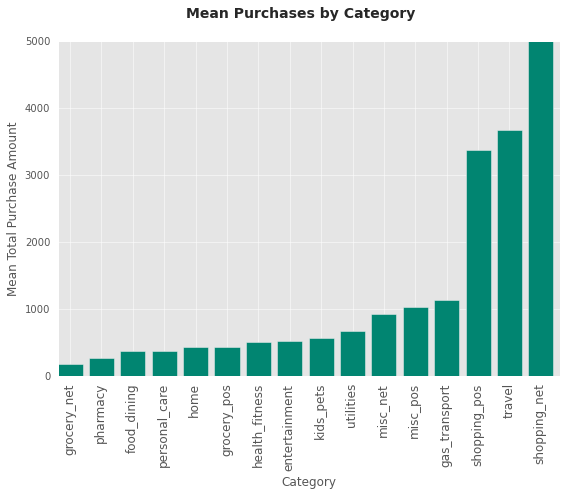

In [458]:
df = df[df.loc[:, 'group_by_value'].apply(lambda x: str(x) != 'None')]
df.sort('mean',inplace=True)

fig = plt.figure(figsize = (9,6))
ax = plt.subplot(111)

x = np.arange(1,len(df)+1,1)
width = 0.8

colors = brewer2mpl.get_map('BrBG', 'diverging', 4).mpl_colors

bar = plt.bar(x, df.loc[:, 'mean'], width, color = colors[3])

for label in ax.get_xticklines():
    label.set_visible(False)

for label in ax.get_yticklines():
    label.set_visible(False)

plt.xticks(x+width/2, df.group_by_value.values, rotation = 90, fontsize = 12)
plt.xlabel('Category')
plt.ylabel('Mean Total Purchase Amount')
plt.suptitle('Mean Purchases by Category', 
             fontsize = 14, fontweight = 'bold', color = '#262626')
x = plt.xlim([1, 17])
y = plt.ylim([0, 5000])
plt.show()



In [459]:
q = ["\
DROP TABLE IF EXISTS spending cascade; \
CREATE TABLE spending AS ( \
   SELECT ssn, age, gender, count(*) as num_trans, \
    city_pop, \
    sum(food_dining) as food_dining, \
    sum(utilities) as utilities, \
    sum(grocery_net) as grocery_net, \
    sum(home) as home, \
    sum(pharmacy) as pharmacy, \
    sum(shopping_pos) as shopping_pos, \
    sum(kids_pets) as kids_pets, \
    sum(personal_care) as personal_care, \
    sum(misc_pos) as misc_pos, \
    sum(gas_transport) as gas_transport, \
    sum(misc_net) as misc_net, \
    sum(health_fitness) as health_fitness, \
    sum(shopping_net) as shopping_net, \
    sum(travel) as travel \
    FROM( \
    SELECT ssn as ssn, extract(years from age(NOW(),dob)) as age, \
    city_pop, \
    case when gender = 'M' then 0 else 1 end as gender,\
    case when category = 'food_dining' then (amt) else 0 end as food_dining,\
    case when category = 'utilities' then (amt) else 0 end as utilities, \
    case when category = 'grocery_net' then (amt) else 0 end as grocery_net, \
    case when category = 'home' then (amt) else 0 end as home, \
    case when category = 'pharmacy' then (amt) else 0 end as pharmacy, \
    case when category = 'shopping_pos' then (amt) else 0 end as shopping_pos, \
    case when category = 'kids_pets' then (amt) else 0 end as kids_pets, \
    case when category = 'personal_care' then (amt) else 0 end as personal_care, \
    case when category = 'misc_pos' then (amt) else 0 end as misc_pos, \
    case when category = 'gas_transport' then (amt) else 0 end as gas_transport, \
    case when category = 'misc_net' then (amt) else 0 end as misc_net, \
    case when category = 'health_fitness' then (amt) else 0 end as health_fitness, \
    case when category = 'shopping_net' then (amt) else 0 end as shopping_net, \
    case when category = 'travel' then (amt) else 0 end as travel \
    FROM trans_fact) GROUPED \
    GROUP BY ssn, age, gender, city_pop \
) DISTRIBUTED RANDOMLY"]

query(q, False)

In [460]:
query(["SELECT * FROM spending LIMIT 5"])

,ssn,age,gender,num_trans,city_pop,food_dining,utilities,grocery_net,home,pharmacy,shopping_pos,kids_pets,personal_care,misc_pos,gas_transport,misc_net,health_fitness,shopping_net,travel
0,010-92-4856,23,0,2206,249,533.77,693.57,149.80,220.67,209.20,4275.26,909.82,520.52,1495.35,1241.89,1268.47,646.71,18214.69,5125.59
1,382-33-3260,28,1,1598,254,224.51,672.76,132.88,437.94,316.89,2688.72,303.76,269.51,840.30,849.24,457.65,488.77,17671.61,2476.33
2,810-17-2155,25,1,3051,171,478.84,1153.88,318.32,684.30,475.47,6569.25,858.29,405.98,1432.19,1677.01,1073.25,816.06,47272.73,5794.81
3,204-08-3463,24,1,1671,130,287.22,580.76,197.29,361.95,233.76,1791.32,424.17,227.14,659.26,850.12,754.24,413.01,23333.40,2306.73
4,596-43-8340,25,0,2774,182,531.56,918.72,219.47,653.22,420.57,4914.51,742.44,493.07,952.68,1688.41,718.62,725.21,39296.88,3176.13


### Train a logistic regression model

http://doc.madlib.net/latest/group__grp__elasticnet.html


In [461]:
features = ['1',
            'city_pop', \
            'num_trans', \
            'food_dining', \
            'utilities', \
            'grocery_net', \
            'home', \
            'pharmacy', \
            'shopping_pos', \
            'kids_pets', \
            'personal_care', \
            'misc_pos', \
            'gas_transport', \
            'misc_net', \
            'health_fitness', \
            'shopping_net', \
            'travel']

feature_array = "'array[" + ",".join(features) + "]'"

q = ["DROP TABLE IF EXISTS logistic; \
DROP TABLE IF EXISTS logistic_summary; \
SELECT madlib.logregr_train( \n \
    'spending', -- input table \n \
     'logistic', -- output table (generated automatically) \n \
     'gender', -- estimand \n " + 
     feature_array + 
     ")"]

print query(q, False)

None


In [462]:
feature_array

"'array[1,city_pop,num_trans,food_dining,utilities,grocery_net,home,pharmacy,shopping_pos,kids_pets,personal_care,misc_pos,gas_transport,misc_net,health_fitness,shopping_net,travel]'"

In [463]:
query(["SELECT * FROM logistic"])

,coef,log_likelihood,std_err,z_stats,p_values,odds_ratios,condition_no,num_rows_processed,num_missing_rows_skipped,num_iterations,variance_covariance
0,"[-0.0112450758159, -3.70357447699e-07, 0.00148...",-1313.407845,"[0.183325604806, 5.66901129742e-07, 0.00073923...","[-0.0613393629754, -0.6533016575, 2.0052279187...","[0.951088942685, 0.513561824074, 0.04493868668...","[0.988817913721, 0.999999629643, 1.00148343205...",325666.076958,2000,0,5,"[[0.0336082773776, -1.37567386492e-09, -2.3788..."


In [464]:
q = ["SELECT unnest(array" + str(features) + ") as feature, \
    unnest(coef) as coefficient, \
    unnest(std_err) as st_err \
    FROM logistic \
    ORDER BY coefficient DESC"]

df = query(q)
df = df[df.feature != '1']
df

,feature,coefficient,st_err
0,pharmacy,0.002101,0.001250
1,kids_pets,0.001635,0.000594
2,grocery_net,0.001611,0.001022
3,num_trans,0.001482,0.000739
4,personal_care,0.000755,0.000592
5,home,0.000464,0.000521
6,shopping_pos,0.000115,0.000058
7,shopping_net,0.000009,0.000013
8,city_pop,-0.000000,0.000001
9,travel,-0.000033,0.000027


### PLOT COEFFICIENTS

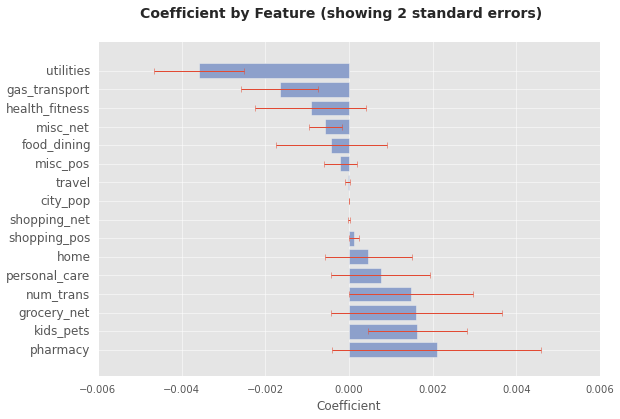

In [465]:
fig = plt.figure(figsize = (9,6))
ax = plt.subplot(111)

x = np.arange(1,len(df)+1,1)
width = 0.8

colors = brewer2mpl.get_map('Set2', 'qualitative', 4).mpl_colors

bar = plt.barh(x, df.loc[:, 'coefficient'], width, \
        xerr = df.loc[:, 'st_err'].apply(lambda x: x*2), color = colors[2])

for label in ax.get_xticklines():
    label.set_visible(False)

for label in ax.get_yticklines():
    label.set_visible(False)

plt.yticks(x+width/2, df.feature.values, rotation = 0, fontsize = 12)
# plt.ylabel('Feature')
plt.xlabel('Coefficient')
plt.suptitle('Coefficient by Feature (showing 2 standard errors)', 
             fontsize = 14, fontweight = 'bold', color = '#262626')
plt.show()

In [466]:
q = ["SELECT s.ssn, \
    madlib.logregr_predict(m.coef, " + \
    feature_array + "), \
    s.gender \
    FROM spending s, logistic m \
    ORDER BY s.ssn"]

query(q)

psycopg2.DataError('array value must start with "{" or dimension information\nLINE 1: SELECT s.ssn,     madlib.logregr_predict(m.coef, \'array[1,ci...\n                          ^\n')

In [467]:
q = ["SELECT CASE WHEN \
    madlib.logregr_predict(coef, " + feature_array[1:-1] + ") \
    = 'FALSE' THEN 0 ELSE 1 END AS prediction, \
    s.gender as actual \
    FROM logistic m, spending s"] 

df = query(q)
df.head()

,prediction,actual
0,1,0
1,0,0
2,1,0
3,1,1
4,1,0


# plot features by actual/predicted

### confusion matrix

In [468]:
confusion_matrix(df.loc[:, 'actual'], df.loc[:, 'prediction'])

array([[586, 412],
       [448, 554]])

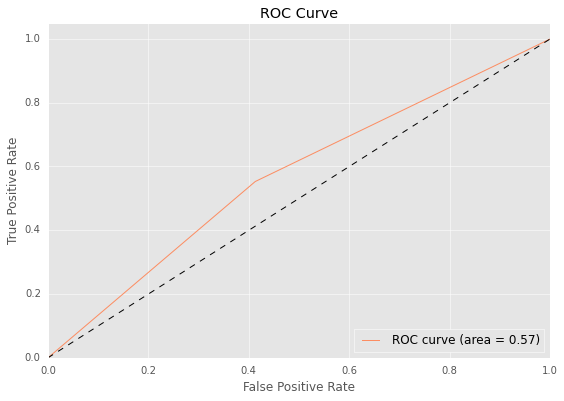

In [469]:
fig = plt.figure(figsize = (9,6))
ax = plt.subplot(111)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(df.loc[:, 'actual'], df.loc[:, 'prediction'])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(df.loc[:, 'actual'], df.loc[:, 'prediction'])
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Plot of a ROC curve for a specific class
# plt.figure()
plt.plot(fpr[0], tpr[0], label='ROC curve (area = %0.2f)' % roc_auc[0], color=colors[1])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
for label in ax.get_xticklines():
    label.set_visible(False)

for label in ax.get_yticklines():
    label.set_visible(False)

plt.show()

### Train/Test split using stratified sampling

In [470]:
q = ["SELECT setseed(0.444); \n \
DROP TABLE IF EXISTS training_set CASCADE; \n \
CREATE TABLE training_set AS ( \n \
-- 1. query the columns \n \
WITH assign_random AS ( \n \
    SELECT *, random() as random \n \
    FROM spending \n \
), \n \
-- 2. add a different row count for group type (in this case, just age) \n \
training_rownums AS ( \n \
    SELECT *, ROW_NUMBER() \n \
        OVER (PARTITION BY age, gender ORDER BY random) AS rownum \n \
    FROM assign_random \n \
) \n \
-- 3. sample the lowest 80% of rownums as the training set by group using \n \
----- a correlated subquery (iterate over groups) \n \
SELECT * \n \
    FROM training_rownums tr1 \n \
    WHERE rownum <= ( \n \
        (SELECT MAX(rownum) * 0.8 \n \
        FROM training_rownums tr2 \n \
        WHERE tr1.age = tr2.age AND tr1.gender = tr2.gender \n \
    )) \n \
 )", \
"DROP TABLE IF EXISTS test_set CASCADE; \n \
CREATE TABLE test_set AS ( \n \
-- 1. query the columns \n \
WITH assign_random AS ( \n \
    SELECT *, random() as random  \n \
    FROM spending \n \
), \n \
-- 2. add a different row count for group type (in this case, just age) \n \
test_rownums AS ( \n \
    SELECT *, ROW_NUMBER() OVER (PARTITION BY age, gender ORDER BY random) AS rownum FROM assign_random \n \
) \n \
-- 3. sample the highest 20% of rownums as the test set by group using \n \
----- a correlated subquery (iterate over groups)  \n \
SELECT * \n \
    FROM test_rownums tr1 \n \
    WHERE rownum > ( \n \
        (SELECT MAX(rownum) * 0.8  \n \
        FROM test_rownums tr2  \n \
        WHERE tr1.age = tr2.age AND tr1.gender = tr2.gender \n \
    )) \n \
 )"]

# query(q, False)

In [471]:
q = ["\
SELECT tr.age, tr.gender, train_total, test_total, \
    (train_total::float / (train_total::float + test_total::float)) as train_prop \
FROM \
    (SELECT count(*) as train_total, age, gender \
    FROM training_set \
    GROUP BY age, gender) tr, \
    (SELECT count(*) as test_total, age, gender \
    FROM test_set \
    GROUP BY age, gender) te \
WHERE tr.age = te.age and tr.gender = te.gender \
ORDER BY age, gender"]

df = query(q)
df.head()

,age,gender,train_total,test_total,train_prop
0,16,0,8,2,0.800000
1,16,1,5,2,0.714286
2,17,0,6,2,0.750000
3,17,1,15,4,0.789474
4,18,0,14,4,0.777778


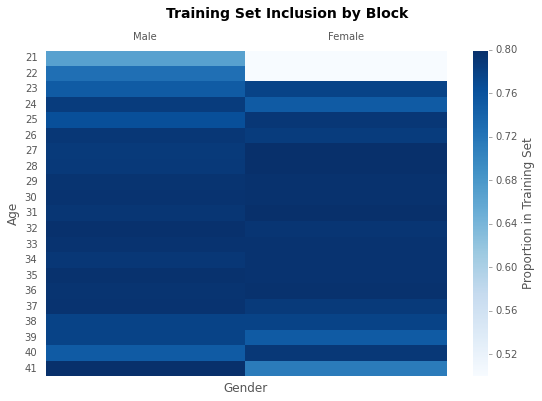

In [472]:
fig = plt.figure(figsize = (9,6))
ax = plt.subplot(111)
fig.subplots_adjust(top=0.88)

heat = df.train_prop.values
heat = heat.reshape(len(heat)/2,2)
heatmap = ax.pcolor(heat, cmap=plt.cm.Blues)

xt = ax.set_xticks(np.arange(heat.shape[1])+0.5, minor=False)
yt = ax.set_yticks(np.arange(heat.shape[0])+0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

column_labels = list(OrderedDict.fromkeys([int(i[0]) for i in df.stack().index]))
row_labels = ['Male', 'Female']

xl = plt.xlim(0,2)
xl = plt.ylim(0,21)

column_labels.reverse()
xtick = ax.set_xticklabels(row_labels, minor=False, rotation = 0)
ytick = ax.set_yticklabels(column_labels, minor=False)    

for label in ax.get_yticklines():
    label.set_visible(False)
for label in ax.get_xticklines():
    label.set_visible(False)

plt.xlabel('Gender')
plt.ylabel('Age')

plt.colorbar(heatmap, label = 'Proportion in Training Set')

plt.suptitle('Training Set Inclusion by Block', fontsize = 14, fontweight = 'bold')
plt.show()

### Train a regularized linear regression model on training set

http://doc.madlib.net/latest/group__grp__elasticnet.html

In [473]:
q = ["DROP TABLE IF EXISTS enet; \n \
SELECT madlib.elastic_net_train( \n \
    'training_set', -- input table \n \
     'enet', -- output table (generated automatically) \n \
     'age', -- dependent variable \n " +
     feature_array.replace('1,','') + ",\n \
     'gaussian', -- GLM family \n \
     0.5, -- alpha \n \
     0.4, -- lambda \n \
     TRUE, -- normalize data \n \
     NULL, -- group by \n \
     'fista' -- optimization algo\n)"]

query(q, False)

In [474]:
query(["SELECT * FROM enet"])

,family,features,features_selected,coef_nonzero,coef_all,intercept,log_likelihood,standardize,iteration_run
0,gaussian,"[city_pop, num_trans, food_dining, utilities, ...","[food_dining, utilities, grocery_net, home, ph...","[-0.00127337199481, 0.000157040866272, 0.00515...","[0.0, 0.0, -0.00127337199481, 0.00015704086627...",23.860717,-3.416937,True,150


In [475]:
query(["SELECT unnest(features_selected) as feature, \
        unnest(coef_nonzero) as coef \
        FROM enet \
        ORDER BY coef DESC"])

,feature,coef
0,pharmacy,0.006479
1,home,0.005653
2,grocery_net,0.005157
3,utilities,0.000157
4,shopping_net,-0.000060
5,misc_pos,-0.000527
6,food_dining,-0.001273
7,misc_net,-0.001509
8,personal_care,-0.001942


In [476]:
q = ["\
SELECT test_set.age as actual, \
    madlib.elastic_net_gaussian_predict( \
    m.coef_all, \
    m.intercept, " + \
    feature_array.replace('1,','')[1:-1] + \
     ") as prediction \
     FROM enet m, test_set"]

df = query(q)
df.head(10)

,actual,prediction
0,22,22.299946
1,22,22.372246
2,29,27.850693
3,25,24.318648
4,32,28.318859
5,23,21.956444
6,23,22.476491
7,19,22.617960
8,26,25.883813
9,24,26.088500


### RMSE

In [477]:
import math
math.sqrt(((df.actual - df.prediction)**2).mean())

2.3457757420672336

# Model Checking

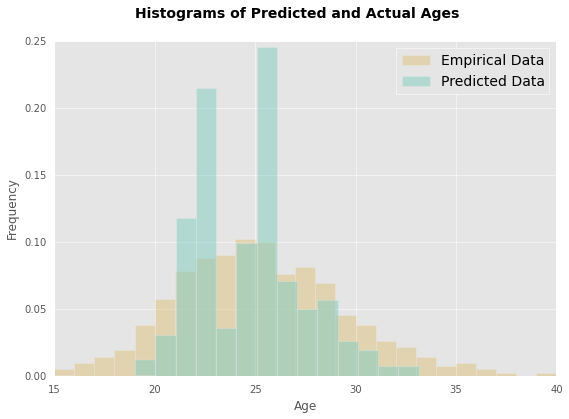

In [478]:
mina = np.floor(df.actual.min())
maxa = np.floor(df.actual.max())

minp = np.floor(df.prediction.min())
maxp = np.floor(df.prediction.max())

fig = plt.figure(figsize = (9,6))
ax = plt.subplot(111)

set2 = brewer2mpl.get_map('BrBG', 'diverging', 4).mpl_colors

plt.hist(df.actual.values, bins = maxa-mina, normed = True, 
     histtype = 'bar', cumulative=False, color = set2[1], alpha = .5, label = 'Empirical Data')
plt.hist(df.prediction.values, bins = maxp-minp, normed = True, 
     histtype = 'bar', cumulative=False, color = set2[2], alpha = .5, label = 'Predicted Data')

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.suptitle('Histograms of Predicted and Actual Ages', 
             fontsize = 14, fontweight = 'bold')
ax.legend(loc = 'best', fontsize = 14)
          
for label in ax.get_xticklines():
    label.set_visible(False)
for label in ax.get_yticklines():
    label.set_visible(False)

plt.show()    

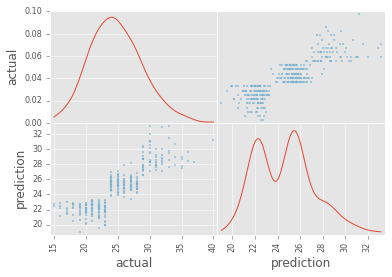

In [479]:
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
smat = scatter_matrix(df, diagonal='kde')

## PL/Python

### Syntax:

### Simple use case -- categorize city size

In [481]:
q = ["\
CREATE OR REPLACE FUNCTION city_type(population integer) \
    RETURNS text                                         \
AS                                                       \
$$\n\
  if population > 100000:\n\
    return 'huge'\n\
  elif population > 250000:\n\
    return 'big'\n\
  elif population > 50000:\n\
    return 'medium'\n\
  else:\n\
    return 'small'\n\
$$                                                       \
LANGUAGE PLPYTHONU"]

query(q, False)

In [482]:
query(["\
SELECT ssn, city_pop, city_type(city_pop) \
FROM spending \
ORDER BY city_pop DESC"]).head()

,ssn,city_pop,city_type
0,516-74-3661,1595797,huge
1,065-04-7845,1526206,huge
2,322-30-8263,1417793,huge
3,096-27-0254,1417793,huge
4,560-25-3800,1241364,huge


### Column-wise array

In [483]:
q = ["\
SELECT array_agg(city), array_agg(state), array_agg(city_pop) \
FROM (SELECT city, state, city_pop \
  FROM trans_fact \
  GROUP BY city, state, city_pop\
  LIMIT 10) c"]

query(q)

,array_agg,array_agg,array_agg
0,"[Ludlow, Parkman, Osgood, Linville Falls, Eden...","[MO, WY, OH, NC, SD, ND, MO, OR, IA, NY]","[240, 268, 274, 89, 299, 148, 298, 271, 115, 207]"


### Row-wise array

In [484]:
q = ["\
SELECT array[city, state, city_pop::text] \
FROM trans_fact \
GROUP BY city, state, city_pop"]

query(q).head()

,array
0,"[Point Lay, AK, 189]"
1,"[Low Moor, VA, 270]"
2,"[Chama, CO, 276]"
3,"[Hobucken, NC, 137]"
4,"[Luray, SC, 269]"


### Representing a matrix

In [485]:
q = ["\
CREATE ORDERED AGGREGATE array_agg_array(anyarray) \
( \
    SFUNC = array_cat, \
    STYPE = anyarray \
)"]

query(q, False)

psycopg2.ProgrammingError('function "array_agg_array" already exists with same argument types\n')

In [486]:
q = ["\
SELECT array_agg_array(train_x order by tr2.ssn) as tr_x, \
    max(array_upper(train_x, 1)) as num_features, \
    array_agg(tr.gender order by tr.ssn) as label \
FROM training_set tr, \
    (SELECT ssn, ARRAY[age, num_trans, food_dining] as train_x \
        FROM training_set\
        LIMIT 10) tr2"]

query(q)

,tr_x,num_features,label
0,"[25.0, 2842.0, 434.33, 25.0, 2842.0, 434.33, 2...",3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


## SVM in PL/Python

In [487]:
q = ["DROP TYPE IF EXISTS svm CASCADE;\
CREATE TYPE svm \
AS\
(\
 score float\
)",
"DROP FUNCTION IF EXISTS svmpy(float[], int, int[], float, text) CASCADE; \
CREATE OR REPLACE FUNCTION \
svmpy(train_x float[], num_features int, \
        labels int[], cval float, kern text) \
    RETURNS svm \
AS \
$$ \n\
    from sklearn import svm \n\
    import numpy as np \n\
    from sklearn.cross_validation import StratifiedShuffleSplit \n\
\n\
    all_x = np.array(train_x).reshape(len(train_x)/num_features, num_features) \n\
    y = np.array(labels) \n\
\n\
    sss = StratifiedShuffleSplit(y, 1, test_size=0.2, random_state=0) \n\
    for train_index, test_index in sss: \n\
        X_train, X_test = all_x[train_index], all_x[test_index] \n\
        y_train, y_test = y[train_index], y[test_index] \n\
 \n\
    mdl = svm.SVC(C = cval, kernel = kern) \n\
    mdl.fit(X_train, y_train) \n\
 \n\
    return [mdl.score(X_test, y_test)] \n\
$$ \
LANGUAGE PLPYTHONU"]

query(q, False)

In [488]:
query(["SELECT (svmpy(x, n, y, 2.0, 'rbf')).*\
FROM\
(SELECT\
        array_agg_array(train_x order by ssn) as x,\
        max(array_upper(train_x, 1)) as n,\
    array_agg(gender order by ssn) as y\
    FROM\
        (SELECT ssn, gender, ARRAY[age::float,\
            num_trans::float, food_dining, utilities, grocery_net, \
                  home, pharmacy, shopping_pos, kids_pets, personal_care,\
                  misc_pos, gas_transport, misc_net, health_fitness, \
                  shopping_net, travel] as train_x \
        FROM training_set) q1) q2"])

,score
0,0.5


In [489]:
query(["SELECT (svmpy(x, n, y, 2.0, 'rbf')).*\
FROM\
(SELECT\
        array_agg_array(train_x order by ssn) as x,\
        max(array_upper(train_x, 1)) as n,\
    array_agg(gender order by ssn) as y\
    FROM\
        (SELECT ssn, gender, ARRAY[age::float,\
            num_trans::float, food_dining, utilities, grocery_net, \
                  home, pharmacy, shopping_pos, kids_pets, personal_care,\
                  misc_pos, gas_transport, misc_net, health_fitness, \
                  shopping_net, travel] as train_x \
        FROM training_set) q1) q2"])

,score
0,0.5


In [498]:
query(["DROP VIEW IF EXISTS svm_group; \
        CREATE VIEW svm_group AS\
        SELECT city_size, \
        array_agg_array(train_x order by ssn) as x,\
        max(array_upper(train_x, 1)) as n,\
    array_agg(gender order by ssn) as y\
    FROM\
        (SELECT ssn, gender, \
        CASE WHEN city_pop > 200000 THEN 'BIG' \
        ELSE 'SMALL' END AS city_size, \
        ARRAY[age::float,\
            num_trans::float, food_dining, utilities, grocery_net, \
                  home, pharmacy, shopping_pos, kids_pets, personal_care,\
                  misc_pos, gas_transport, misc_net, health_fitness, \
                  shopping_net, travel] as train_x \
        FROM training_set) q1 GROUP BY city_size"], False)

In [499]:
query(["SELECT * FROM svm_group"])

,city_size,x,n,y
0,BIG,"[31.0, 1383.0, 206.49, 816.12, 284.74, 609.42,...",16,"[0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]"
1,SMALL,"[21.0, 1664.0, 301.12, 463.44, 89.36, 168.48, ...",16,"[1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, ..."


In [500]:
query(["SELECT city_size, (svmpy(x, n, y, 2.0, 'rbf')).* FROM svm_group"])

,city_size,score
0,BIG,0.666667
1,SMALL,0.500000


### How this data was generated via PL/Python:

Main line: customer().generate_transactions()

In [501]:
import sys
import os
import cPickle as pickle

# orig_cwd  = os.getcwd()
# os.chdir(orig_cwd + '/datagen_offers')
sys.path.append('./src')
f = open('./pickles/generate_customer.pickle', 'rb')

customer = pickle.load(f)
alltrans = customer().generate_transactions()
rows = ['|'.join(a) for a in alltrans]
print rows[1]

182-47-7125|Geraldo|Krajcik|M|392 Effertz Lodge Apt. 153|Archer|NE|68816|41.1782|-98.1182|180|Editor, commissioning|1982-09-13|2981313|male_30_40_smaller_cities.json|1|2013-01-01|home|20.58|||


In [502]:
q= ["\
DROP TYPE IF EXISTS transaction CASCADE; \
CREATE TYPE transaction AS ( \
ssn text, \
first text, \
last text, \
gender text, \
street text, \
city text, \
state text, \
zip text, \
lat text, \
long text, \
city_pop text, \
job text, \
dob text, \
acct_num text, \
profile text, \
transnum text, \
transdate text, \
category text, \
amt text, \
offer_id text, \
expiration_date text, \
response text)"]

query(q, False)

In [503]:
q = ["\
DROP FUNCTION IF EXISTS customer() CASCADE; \
CREATE OR REPLACE FUNCTION customer() \
	RETURNS SETOF transaction \
AS \
$$   \
	import cPickle as pickle \n\
	import faker \n\
	from faker import Faker \n\
	import numpy as np \n\
	import sys \n\
	import os \n\
\n\
	sys.path.append('/data1/datagen_offers/src') \n\
	sys.path.append('/data1/datagen_offers') \n\
	os.chdir('/data1/datagen_offers') \n\
\n\
	customer = pickle.load(open('generate_customer.pickle', 'rb')) \n\
	alltrans = customer(np.random.random()).generate_transactions() \n\
\n\
	return [a for a in alltrans] \n\
$$  \
LANGUAGE PLPYTHONU"]

query(q, False)

In [504]:
q = ["\
SELECT (t).ssn,\
(t).first,\
(t).last,\
(t).gender,\
(t).street,\
(t).city,\
(t).state,\
(t).zip,\
(t).lat,\
(t).long,\
(t).city_pop,\
(t).job,\
(t).dob,\
(t).acct_num,\
(t).profile,\
(t).transnum,\
(t).transdate,\
(t).category,\
(t).amt, \
(t).offer_id ,\
(t).expiration_date, \
(t).response \
FROM (SELECT customer() as t) q2"]

new_data = query(q)

In [505]:
new_data.head()

,ssn,first,last,gender,street,city,state,zip,lat,long,...,dob,acct_num,profile,transnum,transdate,category,amt,offer_id,expiration_date,response
0,259-16-0101,Dorothea,Russel,F,1112 Lindgren Valleys Suite 634,West Lebanon,NY,12195,42.4794,-73.4748,...,1991-02-24,9420782,young_adults.json,0,2014-01-02,misc_net,1.59,NULL,NULL,NULL
1,259-16-0101,Dorothea,Russel,F,1112 Lindgren Valleys Suite 634,West Lebanon,NY,12195,42.4794,-73.4748,...,1991-02-24,9420782,young_adults.json,1,2014-01-03,grocery_pos,62.49,NULL,NULL,NULL
2,259-16-0101,Dorothea,Russel,F,1112 Lindgren Valleys Suite 634,West Lebanon,NY,12195,42.4794,-73.4748,...,1991-02-24,9420782,young_adults.json,2,2014-01-05,pharmacy,9.5,NULL,NULL,NULL
3,259-16-0101,Dorothea,Russel,F,1112 Lindgren Valleys Suite 634,West Lebanon,NY,12195,42.4794,-73.4748,...,1991-02-24,9420782,young_adults.json,3,2014-01-09,travel,12.09,NULL,NULL,NULL
4,259-16-0101,Dorothea,Russel,F,1112 Lindgren Valleys Suite 634,West Lebanon,NY,12195,42.4794,-73.4748,...,1991-02-24,9420782,young_adults.json,4,2014-01-10,utilities,117.34,NULL,NULL,NULL


In [506]:
q = ["\
SELECT test_set.age as actual, \
    madlib.elastic_net_gaussian_predict( \
    m.coef_all, \
    m.intercept, " + \
    feature_array.replace('1,','')[1:-1] + \
     ") as prediction \
     FROM enet m, test_set"]

df = query(q)
df.head(10)

,actual,prediction
0,22,22.299946
1,22,22.372246
2,29,27.850693
3,25,24.318648
4,32,28.318859
5,23,21.956444
6,23,22.476491
7,19,22.617960
8,26,25.883813
9,24,26.088500


### 